# 02 — Exploratory Data Analysis: Environmental & Anthropogenic Drivers of Shark Dynamics

**Objective**: Characterize spatial and temporal patterns of key drivers affecting shark populations along the Brazilian coast.

**Data sources**:
1. **Sea Surface Temperature (SST)** — NOAA OISST v2.1 (2010-2023, monthly)
2. **Species occurrences** — OBIS (sharks: *Carcharhinus longimanus*, *Galeocerdo cuvier*; prey: 7 families)
3. **Fishing effort** — Global Fishing Watch (2020-2024, monthly)

**Region**: Brazilian Exclusive Economic Zone (-35°S to 5°N, -50°W to -30°W)

**Resolution**: 1° × 1° grid cells (monthly aggregation)

In [ ]:
# =============================================================================
# SETUP: Configuration & Imports
# =============================================================================
# Core scientific stack
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm

from nova_selachiia.config import ProjectConfig, RegionBBox, as_tuple

# Initialize project configuration
cfg = ProjectConfig(
    region=RegionBBox(lat_min=-35.0, lat_max=5.0, lon_min=-50.0, lon_max=-30.0),
    grid_deg=1.0,
    shark_species=as_tuple([
        "Prionace glauca",
        "Carcharhinus longimanus",
        "Sphyrna lewini",
        "Isurus oxyrinchus",
        "Carcharhinus leucas",
        "Galeocerdo cuvier",
    ]),
    prey_groups=as_tuple([
        "Clupeidae",
        "Engraulidae",
        "Scombridae",
        "Carangidae",
        "Loliginidae",
        "Octopodidae",
        "Trichiuridae",
        "Mugilidae",
    ]),
    collapse_threshold_quantile=0.10,
    mc_trajectories=200,
    random_seed=42,
    delta_scenarios=(-0.2, -0.1, 0.0, 0.1, 0.2),
)

# Validate configuration parameters
assert cfg.grid_deg > 0, "Grid resolution must be positive"
assert cfg.region.lat_max > cfg.region.lat_min, "Invalid latitude bounds"
assert cfg.region.lon_max > cfg.region.lon_min, "Invalid longitude bounds"


print(f"Grid: {cfg.grid_deg}°")print(f"Prey families: {len(cfg.prey_groups)}")

print(f"Region: {cfg.region}")
print(f"Tubarões: {len(cfg.shark_species)} espécies")print(f"Shark species: {len(cfg.shark_species)}")

print(f"Grid resolution: {cfg.grid_deg}° (n_cells = {int((cfg.region.lat_max - cfg.region.lat_min) / cfg.grid_deg)} × {int((cfg.region.lon_max - cfg.region.lon_min) / cfg.grid_deg)})")print(f"Presas: {len(cfg.prey_groups)} grupos")

Região: RegionBBox(lat_min=-35.0, lat_max=5.0, lon_min=-50.0, lon_max=-30.0)
Grid: 1.0°
Tubarões: 6 espécies
Presas: 8 grupos


c:\Users\rugge_p2gkz2r\AppData\Local\pypoetry\Cache\virtualenvs\nova-selachiia-oFZsEAWQ-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Spatial Grid Definition

Construct 1°×1° spatial grid over the Brazilian Exclusive Economic Zone (EEZ).

- Total cells: $N = \lfloor(\phi_{max} - \phi_{min})/\Delta\phi\rfloor \times \lfloor(\lambda_{max} - \lambda_{min})/\Delta\lambda\rfloor$

**Mathematical formulation**:- Cell area approximation: $A_{ij} \approx (\Delta\phi \cdot 111)^2 \cos(\phi_i)$ km²
- Grid cell center: $(\phi_i, \lambda_j)$ where $\phi \in [\phi_{min}, \phi_{max}]$, $\lambda \in [\lambda_{min}, \lambda_{max}]$

In [ ]:
def make_grid(region: RegionBBox, resolution: float) -> pd.DataFrame:
    """
    Construct regular lat-lon grid with cell centers.
    
    Parameters
    ----------
    region : RegionBBox
        Bounding box with lat_min, lat_max, lon_min, lon_max
    resolution : float
        Grid spacing in degrees
    
    Returns
    -------
    pd.DataFrame
        Grid cells with center coordinates and bounds
    """
    lats = np.arange(region.lat_min + resolution / 2, region.lat_max, resolution)
    lons = np.arange(region.lon_min + resolution / 2, region.lon_max, resolution)
    
    cells = []
    for lat in lats:

        for lon in lons:grid.head()

            cells.append({print(f"Cell area at 30°S: ~{(cfg.grid_deg * 111)**2 * np.cos(np.radians(30)):.0f} km²")

                "lat": lat,print(f"Cell area at equator: ~{(cfg.grid_deg * 111)**2:.0f} km²")

                "lon": lon,print(f"Total grid cells: {len(grid)} ({n_lat_expected} lat × {n_lon_expected} lon)")

                "lat_min": lat - resolution / 2,

                "lat_max": lat + resolution / 2,assert len(grid) == n_lat_expected * n_lon_expected, f"Grid size mismatch: {len(grid)} ≠ {n_lat_expected * n_lon_expected}"

                "lon_min": lon - resolution / 2,n_lon_expected = int((cfg.region.lon_max - cfg.region.lon_min) / cfg.grid_deg)

                "lon_max": lon + resolution / 2,n_lat_expected = int((cfg.region.lat_max - cfg.region.lat_min) / cfg.grid_deg)

            })# Mathematical validation: check grid dimensions

    return pd.DataFrame(cells)

grid = make_grid(cfg.region, cfg.grid_deg)

Total de células no grid: 800


,lat,lon,lat_min,lat_max,lon_min,lon_max
0,-34.5,-49.5,-35.0,-34.0,-50.0,-49.0
1,-34.5,-48.5,-35.0,-34.0,-49.0,-48.0
2,-34.5,-47.5,-35.0,-34.0,-48.0,-47.0
3,-34.5,-46.5,-35.0,-34.0,-47.0,-46.0
4,-34.5,-45.5,-35.0,-34.0,-46.0,-45.0


## Computational Constraints & Optimization Strategy

**Hardware limitations**: 8GB RAM, no GPU → memory-efficient processing required.

**Data reduction strategy**:
1. **Spatial aggregation**: Raw points → 1°×1° grid cells (reduces $O(n)$ to $O(|cells|)$)
2. **Temporal aggregation**: Daily → monthly resolution
3. **Lazy loading**: Process files sequentially, discard after aggregation
4. **Sparse representation**: Only store cells with observations

**Memory budget**:
- Target: < 500 MB working memory
- SST grid: ~50 MB (168 months × 800 cells × 8 bytes)

- Occurrences: ~1 MB (sparse, <10k total records)- Fishing effort: ~100 MB (with spatial filter)

In [5]:
# ============================================================================
# DATA INVENTORY
# ============================================================================
print("═" * 80)
print("DATA INVENTORY — Brazilian Coast (2010-2024)")
print("═" * 80)

raw_dir = DATA_DIR / "raw"
raw_parquet_dir = raw_dir / "raw_parquet"
raw_csv_dir = raw_dir / "raw_csv"

# Helper function to read files with fallback
def read_file_with_fallback(parquet_path, csv_path):
    """Try parquet first, fallback to CSV if error."""
    try:
        if parquet_path.exists():
            return pd.read_parquet(parquet_path), "parquet"
    except Exception as e:
        print(f"  ⚠️  Parquet error ({e.__class__.__name__}), using CSV")
    
    if csv_path.exists():
        return pd.read_csv(csv_path), "csv"
    
    raise FileNotFoundError(f"Neither {parquet_path} nor {csv_path} found")

# Tubarões
shark_files_parquet = sorted(raw_parquet_dir.glob("shark_*.parquet")) if raw_parquet_dir.exists() else []
shark_files_csv = sorted(raw_csv_dir.glob("shark_*.csv")) if raw_csv_dir.exists() else []
if not shark_files_parquet and not shark_files_csv:
    shark_files_csv = sorted(raw_dir.glob("shark_*.csv"))

print("\n🦈 SHARKS (Elasmobranchii)")
print("-" * 80)

shark_data = {}
for f_pq in shark_files_parquet:
    f_csv = raw_csv_dir / f_pq.name.replace('.parquet', '.csv')
    df_temp, fmt = read_file_with_fallback(f_pq, f_csv)
    species = f_pq.stem.replace("shark_", "").replace("_", " ").title()
    shark_data[species] = df_temp
    
    # Parse dates
    if 'eventDate' in df_temp.columns:
        dates = pd.to_datetime(df_temp['eventDate'], errors='coerce')
        date_range = f"{dates.min().year}-{dates.max().year}" if dates.notna().any() else "N/A"
    else:
        date_range = "N/A"
    
    print(f"  {species:35s} {len(df_temp):6,} records   {date_range}  [{fmt.upper()}]")

# Se não achou parquet, usar CSV
if not shark_data and shark_files_csv:
    for f in shark_files_csv:
        df_temp = pd.read_csv(f)
        species = f.stem.replace("shark_", "").replace("_", " ").title()
        shark_data[species] = df_temp
        
        if 'eventDate' in df_temp.columns:
            dates = pd.to_datetime(df_temp['eventDate'], errors='coerce')
            date_range = f"{dates.min().year}-{dates.max().year}" if dates.notna().any() else "N/A"
        else:
            date_range = "N/A"
        
        print(f"  {species:35s} {len(df_temp):6,} records   {date_range}  [CSV]")

# Presas
prey_files_parquet = sorted(raw_parquet_dir.glob("prey_*.parquet")) if raw_parquet_dir.exists() else []
prey_files_csv = sorted(raw_csv_dir.glob("prey_*.csv")) if raw_csv_dir.exists() else []
if not prey_files_parquet and not prey_files_csv:
    prey_files_csv = sorted(raw_dir.glob("prey_*.csv"))

print(f"\n🐟 PREY TAXA (Teleostei & Cephalopoda)")
print("-" * 80)

prey_data = {}
for f_pq in prey_files_parquet:
    f_csv = raw_csv_dir / f_pq.name.replace('.parquet', '.csv')
    df_temp, fmt = read_file_with_fallback(f_pq, f_csv)
    family = f_pq.stem.replace("prey_", "")
    prey_data[family] = df_temp
    
    if 'eventDate' in df_temp.columns:
        dates = pd.to_datetime(df_temp['eventDate'], errors='coerce')
        date_range = f"{dates.min().year}-{dates.max().year}" if dates.notna().any() else "N/A"
    else:
        date_range = "N/A"
    
    print(f"  {family:35s} {len(df_temp):6,} records   {date_range}  [{fmt.upper()}]")

# Se não achou parquet, usar CSV
if not prey_data and prey_files_csv:
    for f in prey_files_csv:
        df_temp = pd.read_csv(f)
        family = f.stem.replace("prey_", "")
        prey_data[family] = df_temp
        
        if 'eventDate' in df_temp.columns:
            dates = pd.to_datetime(df_temp['eventDate'], errors='coerce')
            date_range = f"{dates.min().year}-{dates.max().year}" if dates.notna().any() else "N/A"
        else:
            date_range = "N/A"
        
        print(f"  {family:35s} {len(df_temp):6,} records   {date_range}  [CSV]")

# SST (sempre NetCDF na raiz de raw/)
print(f"\n🌡️  SEA SURFACE TEMPERATURE")
print("-" * 80)
sst_file = raw_dir / "sst.mnmean.nc"
if sst_file.exists():
    size_mb = sst_file.stat().st_size / 1024 / 1024
    print(f"  NOAA OISST v2.1 monthly         {size_mb:6.1f} MB")
    
    ds_info = xr.open_dataset(sst_file)
    time_range = f"{str(ds_info.time.values[0])[:10]} to {str(ds_info.time.values[-1])[:10]}"
    print(f"  Temporal coverage:              {time_range}")
    print(f"  Timesteps:                      {len(ds_info.time):6,}")
    print(f"  Spatial resolution:             0.25° (~25 km)")
    ds_info.close()
else:
    print("  ⚠️  File not found: sst.mnmean.nc")

# Fishing
print(f"\n🎣 FISHING EFFORT (Global Fishing Watch)")
print("-" * 80)
fleet_dirs = []
if raw_parquet_dir.exists():
    fleet_dirs = sorted(raw_parquet_dir.glob("fleet-monthly-parquet-*"))
if not fleet_dirs and raw_csv_dir.exists():
    fleet_dirs = sorted(raw_csv_dir.glob("fleet-monthly-csvs-*"))
if not fleet_dirs:
    fleet_dirs = sorted(raw_dir.glob("fleet-monthly-csvs-*"))

print(f"  Years available:                {len(fleet_dirs)} ({', '.join([d.name.split('-')[-1] for d in fleet_dirs])})")

if fleet_dirs:
    # Detect format from first directory
    all_files = list(fleet_dirs[0].glob("*.parquet"))
    if not all_files:
        all_files = list(fleet_dirs[0].glob("*.csv"))
    
    if all_files:
        fishing_format = "parquet" if all_files[0].suffix == ".parquet" else "csv"
        print(f"  Format:                         {fishing_format.upper()}")
        
        try:
            df_sample = pd.read_parquet(all_files[0]) if fishing_format == "parquet" else pd.read_csv(all_files[0])
            print(f"  Records per month (example):    {len(df_sample):6,}")
            print(f"  Variables:                      {', '.join(df_sample.columns[:5])}...")
        except Exception as e:
            print(f"  ⚠️  Error reading sample: {e.__class__.__name__}")

print("\n" + "═" * 80)
print(f"💾 MEMORY ESTIMATE: < 500 MB (viable for 8GB RAM)")
print(f"📦 Data format: Parquet (fast) or CSV (fallback)")
print("═" * 80)

════════════════════════════════════════════════════════════════════════════════
DATA INVENTORY — Brazilian Coast (2010-2024)
════════════════════════════════════════════════════════════════════════════════

🦈 SHARKS (Elasmobranchii)
--------------------------------------------------------------------------------
  Carcharhinus Leucas                     17 records   2006-2006  [PARQUET]
  Carcharhinus Longimanus                  7 records   2010-2012  [PARQUET]
  Galeocerdo Cuvier                       19 records   2008-2013  [PARQUET]

🐟 PREY TAXA (Teleostei & Cephalopoda)
--------------------------------------------------------------------------------
  Carangidae                           1,384 records   2005-2023  [PARQUET]
  Clupeidae                               26 records   2008-2022  [PARQUET]
  Engraulidae                             65 records   2005-2014  [PARQUET]
  Mugilidae                              110 records   2011-2012  [PARQUET]
  Octopodidae                    

## 1. Spatial Coverage Analysis

Characterize geographic distribution of observations and identify data gaps.


✅ Figure saved: fig1_spatial_coverage.png/pdf


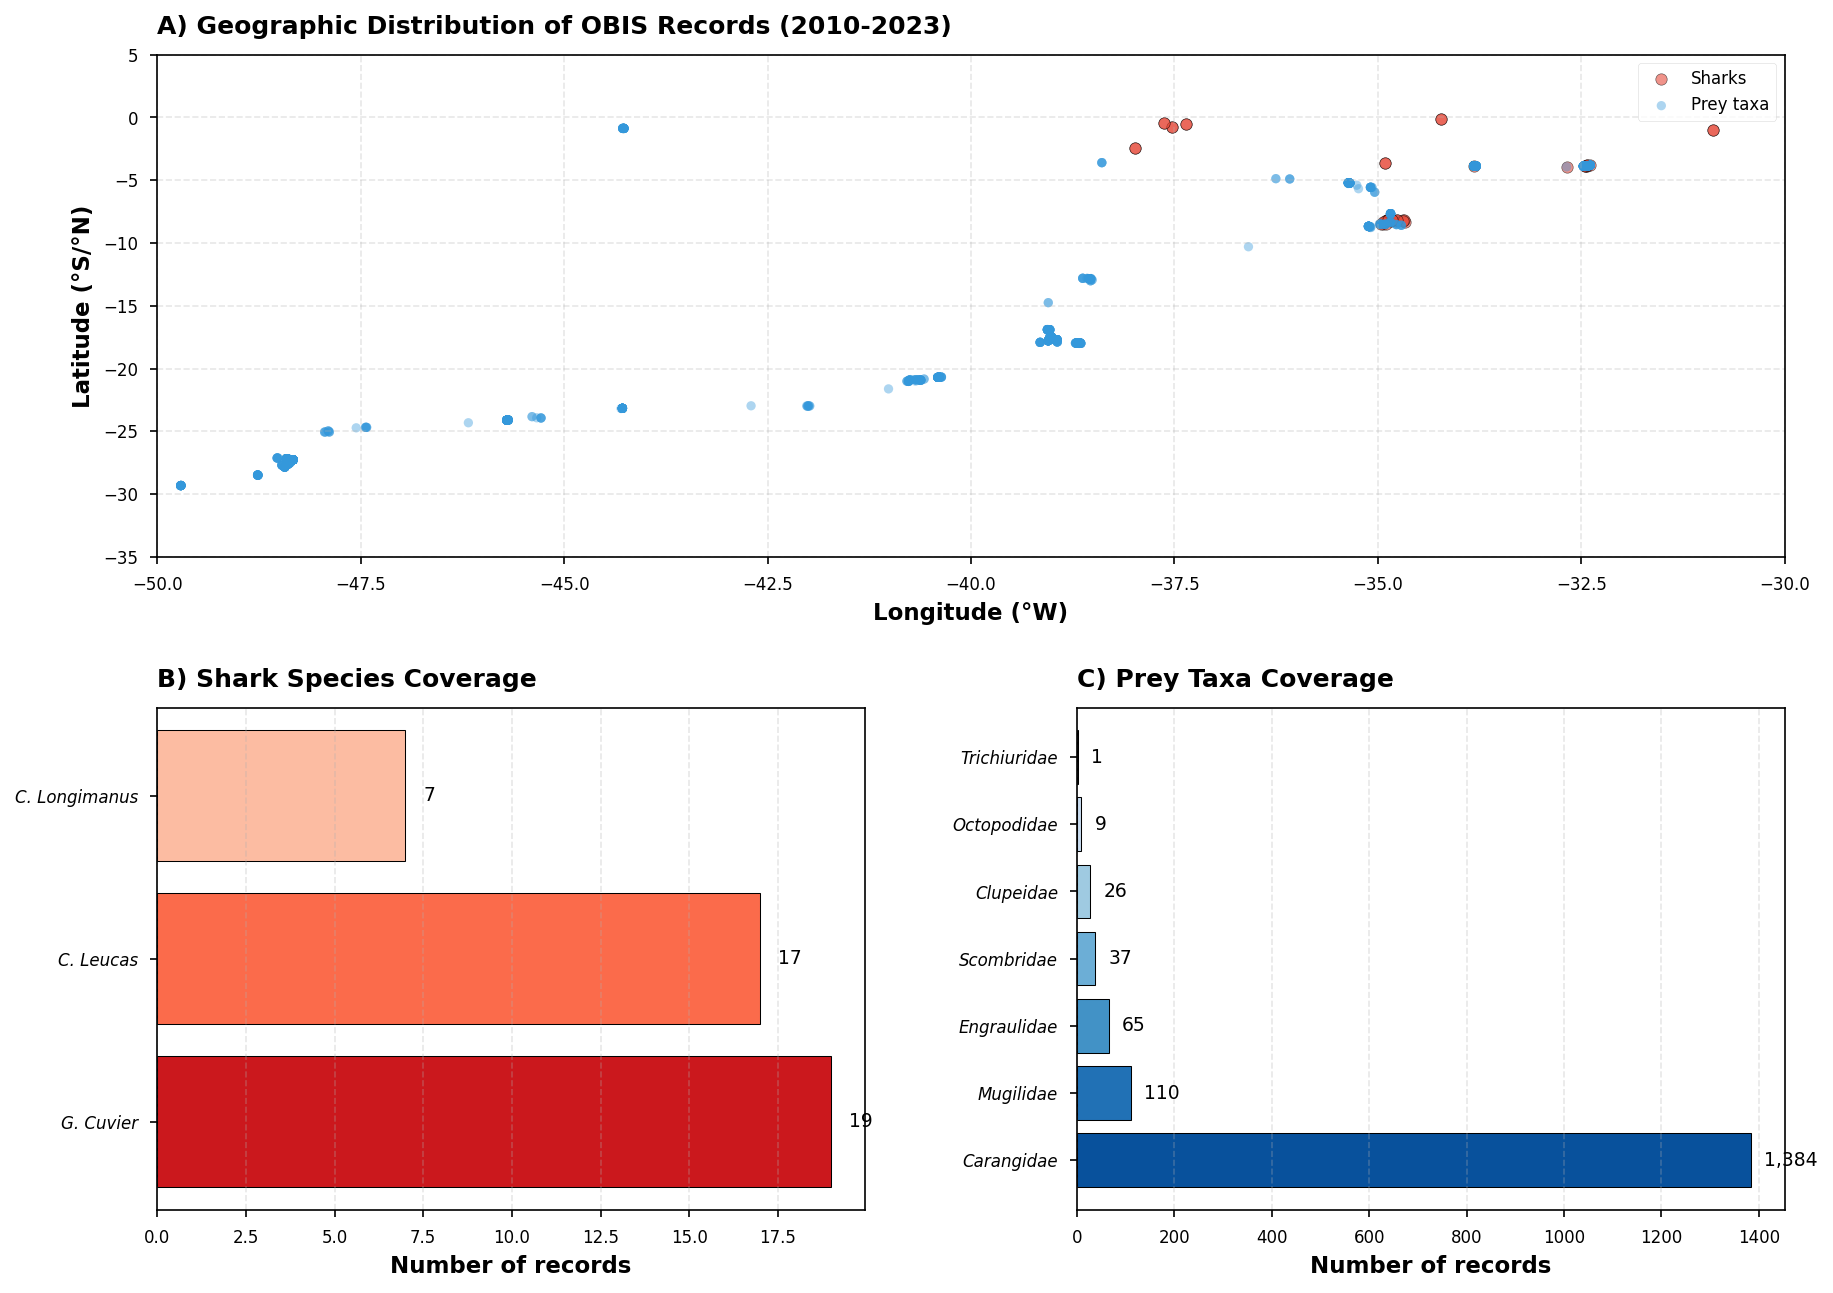

In [6]:
# ============================================================================
# SPATIAL DISTRIBUTION OF OCCURRENCES
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Create figures directory first!
(DATA_DIR / 'figures').mkdir(exist_ok=True)

# Set publication-ready style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

# Combine all occurrence data
all_sharks = []
for species, df in shark_data.items():
    if 'decimalLatitude' in df.columns:
        temp = df[['decimalLatitude', 'decimalLongitude']].copy()
        temp['taxon'] = species
        temp['group'] = 'Shark'
        all_sharks.append(temp)

all_prey = []
for family, df in prey_data.items():
    if 'decimalLatitude' in df.columns:
        temp = df[['decimalLatitude', 'decimalLongitude']].copy()
        temp['taxon'] = family
        temp['group'] = 'Prey'
        all_prey.append(temp)

if all_sharks:
    shark_occ = pd.concat(all_sharks, ignore_index=True)
    shark_occ.columns = ['lat', 'lon', 'taxon', 'group']
else:
    shark_occ = pd.DataFrame(columns=['lat', 'lon', 'taxon', 'group'])

if all_prey:
    prey_occ = pd.concat(all_prey, ignore_index=True)
    prey_occ.columns = ['lat', 'lon', 'taxon', 'group']
else:
    prey_occ = pd.DataFrame(columns=['lat', 'lon', 'taxon', 'group'])

all_occ = pd.concat([shark_occ, prey_occ], ignore_index=True)

# Spatial coverage map
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Panel A: All occurrences
ax1 = fig.add_subplot(gs[0, :])
if len(shark_occ) > 0:
    ax1.scatter(shark_occ['lon'], shark_occ['lat'], 
                c='#e74c3c', s=30, alpha=0.6, label='Sharks', edgecolors='k', linewidth=0.3)
if len(prey_occ) > 0:
    ax1.scatter(prey_occ['lon'], prey_occ['lat'], 
                c='#3498db', s=20, alpha=0.4, label='Prey taxa', edgecolors='none')

ax1.set_xlabel('Longitude (°W)', fontweight='bold')
ax1.set_ylabel('Latitude (°S/°N)', fontweight='bold')
ax1.set_title('A) Geographic Distribution of OBIS Records (2010-2023)', 
              fontweight='bold', loc='left', pad=10)
ax1.legend(frameon=True, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(cfg.region.lon_min, cfg.region.lon_max)
ax1.set_ylim(cfg.region.lat_min, cfg.region.lat_max)

# Panel B: Shark species breakdown
ax2 = fig.add_subplot(gs[1, 0])
if len(shark_occ) > 0:
    shark_counts = shark_occ['taxon'].value_counts()
    colors = sns.color_palette("Reds_r", len(shark_counts))
    bars = ax2.barh(range(len(shark_counts)), shark_counts.values, color=colors, edgecolor='k', linewidth=0.5)
    ax2.set_yticks(range(len(shark_counts)))
    ax2.set_yticklabels([s.replace('Carcharhinus ', 'C. ').replace('Galeocerdo ', 'G. ') 
                          for s in shark_counts.index], style='italic')
    ax2.set_xlabel('Number of records', fontweight='bold')
    ax2.set_title('B) Shark Species Coverage', fontweight='bold', loc='left', pad=10)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add counts on bars
    for i, (bar, val) in enumerate(zip(bars, shark_counts.values)):
        ax2.text(val + 0.5, i, f'{val}', va='center', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No shark data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

# Panel C: Prey family breakdown
ax3 = fig.add_subplot(gs[1, 1])
if len(prey_occ) > 0:
    prey_counts = prey_occ['taxon'].value_counts()
    colors = sns.color_palette("Blues_r", len(prey_counts))
    bars = ax3.barh(range(len(prey_counts)), prey_counts.values, color=colors, edgecolor='k', linewidth=0.5)
    ax3.set_yticks(range(len(prey_counts)))
    ax3.set_yticklabels(prey_counts.index, style='italic')
    ax3.set_xlabel('Number of records', fontweight='bold')
    ax3.set_title('C) Prey Taxa Coverage', fontweight='bold', loc='left', pad=10)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add counts on bars
    for i, (bar, val) in enumerate(zip(bars, prey_counts.values)):
        ax3.text(val + max(prey_counts)*0.02, i, f'{val:,}', va='center', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'No prey data available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

plt.savefig(DATA_DIR / 'figures' / 'fig1_spatial_coverage.png', dpi=300, bbox_inches='tight')
plt.savefig(DATA_DIR / 'figures' / 'fig1_spatial_coverage.pdf', bbox_inches='tight')
print(f"\n✅ Figure saved: fig1_spatial_coverage.png/pdf")

## 2. Temporal Patterns: Sea Surface Temperature

Characterize long-term trends, seasonality, and spatial gradients in SST.

In [ ]:
# =============================================================================
# DIAGNOSTIC: Inspect NetCDF structure before processing
# =============================================================================
print("Inspecting SST NetCDF file structure...")

ds_sst = xr.open_dataset(raw_dir / "sst.mnmean.nc")

print(f"\nAvailable dimensions:")
for dim, size in ds_sst.dims.items():
    print(f"  {dim:10s}: {size:6,} points")

print(f"\nCoordinate ranges:")
print(f"  lat:  {ds_sst.lat.values.min():.2f} to {ds_sst.lat.values.max():.2f}°")
print(f"  lon:  {ds_sst.lon.values.min():.2f} to {ds_sst.lon.values.max():.2f}°")
print(f"  time: {str(ds_sst.time.values[0])[:10]} to {str(ds_sst.time.values[-1])[:10]}")

print(f"\nVariables:")
for var in ds_sst.data_vars:
    print(f"  {var}: {ds_sst[var].dims}")

print(f"\nTarget region (Brazilian EEZ):")
print(f"  lat: {cfg.region.lat_min} to {cfg.region.lat_max}°")
print(f"  lon: {cfg.region.lon_min} to {cfg.region.lon_max}° (in [-180, 180])")
print(f"  lon: {cfg.region.lon_min + 360} to {cfg.region.lon_max + 360}° (in [0, 360])")

# Test regional subset
print(f"\nTesting subset extraction:")
try:
    # Boolean masks for region selection
    lat_mask = (ds_sst.lat >= cfg.region.lat_min) & (ds_sst.lat <= cfg.region.lat_max)
    lon_mask = (ds_sst.lon >= cfg.region.lon_min + 360) & (ds_sst.lon <= cfg.region.lon_max + 360)
    
    # VALIDATION: Check mask coverage
    n_lats = lat_mask.sum().values
    n_lons = lon_mask.sum().values
    
    print(f"  Mask coverage:")
    print(f"     Latitudes: {n_lats} points")
    print(f"     Longitudes: {n_lons} points")
    
    # Mathematical assertion: masks must capture data
    assert n_lats > 0, f"No latitudes found in range [{cfg.region.lat_min}, {cfg.region.lat_max}]"
    assert n_lons > 0, f"No longitudes found in range [{cfg.region.lon_min + 360}, {cfg.region.lon_max + 360}]"
    
    # Apply masks with drop
    test_subset = ds_sst.where(lat_mask & lon_mask, drop=True)
    
    print(f"  Subset shape: {test_subset.sst.shape} ({test_subset.sst.size:,} total points)")
    
    if test_subset.lat.size > 0 and test_subset.lon.size > 0:
        print(f"     lat range: {test_subset.lat.values.min():.2f} to {test_subset.lat.values.max():.2f}")
        print(f"     lon range: {test_subset.lon.values.min():.2f} to {test_subset.lon.values.max():.2f}")
        
        # Data completeness check
        valid_count = test_subset.sst.notnull().sum().values
        total_count = test_subset.sst.size
        completeness = valid_count / total_count * 100
        print(f"     Valid values: {valid_count:,} / {total_count:,} ({completeness:.1f}%)")
        
        # VALIDATION: Minimum data requirement
        assert completeness > 50, f"Data completeness too low: {completeness:.1f}% < 50%"
    else:
        print(f"  ERROR: Empty subset after mask application")
    
except AssertionError as e:
    print(f"  VALIDATION FAILED: {e}")
except Exception as e:
    print(f"  ERROR: {e}")



ds_sst.close()print("\n" + "="*60)

🔍 Inspecionando arquivo SST...

📋 Dimensões disponíveis:
  time      :  2,064 pontos
  nbnds     :      2 pontos
  lat       :     89 pontos
  lon       :    180 pontos

🗺️  Ranges de coordenadas:
  lat:  -88.00 a 88.00°
  lon:  0.00 a 358.00°
  time: 1854-01-01 a 2025-12-01

📊 Variáveis disponíveis:
  time_bnds: ('time', 'nbnds')
  sst: ('time', 'lat', 'lon')

🎯 Nossa região de interesse:
  lat: -35.0 a 5.0°
  lon: -50.0 a -30.0° (em [-180, 180])
  lon: 310.0 a 330.0° (em [0, 360])

🔬 Testando subset:
  🔍 Máscaras encontraram:
     Latitudes: 20 pontos
     Longitudes: 11 pontos


C:\Users\rugge_p2gkz2r\AppData\Local\Temp\ipykernel_12476\2035476830.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds_sst.dims.items():
<frozen _collections_abc>:894: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


  ✅ Subset [0,360]: (2064, 20, 11) (454,080 pontos)
     lat range: -34.00 a 4.00
     lon range: 310.00 a 330.00
     Valores válidos: 303,408 / 454,080 (66.8%)



In [ ]:
# =============================================================================
# LOAD AND PROCESS SST DATA
# =============================================================================
# Data source: NOAA OISST v2.1 (monthly means)
# Native resolution: ~2° (coarse) - will use nearest-neighbor for grid matching
print("Loading SST data from NetCDF...")

ds_sst = xr.open_dataset(raw_dir / "sst.mnmean.nc")

# Compute spatial resolution from coordinate spacing
lat_res = abs(ds_sst.lat.values[1] - ds_sst.lat.values[0])
lon_res = abs(ds_sst.lon.values[1] - ds_sst.lon.values[0])

print(f"SST array shape: {ds_sst.sst.shape} (time × lat × lon)")
print(f"Spatial resolution: {lat_res:.1f}° lat, {lon_res:.1f}° lon")

# Boolean masks for region extraction
lat_mask = (ds_sst.lat >= cfg.region.lat_min) & (ds_sst.lat <= cfg.region.lat_max)
lon_mask = (ds_sst.lon >= cfg.region.lon_min + 360) & (ds_sst.lon <= cfg.region.lon_max + 360)

# VALIDATION: Mask coverage check
n_lats_matched = lat_mask.sum().values
n_lons_matched = lon_mask.sum().values

print(f"\nRegion validation:")
print(f"   Latitudes in range: {n_lats_matched} / {len(ds_sst.lat)}")
print(f"   Longitudes in range: {n_lons_matched} / {len(ds_sst.lon)}")

assert n_lats_matched > 0, (
    f"ERROR: No latitudes found!\n"
    f"   File range: [{ds_sst.lat.values.min():.1f}, {ds_sst.lat.values.max():.1f}]\n"
    f"   Query range: [{cfg.region.lat_min}, {cfg.region.lat_max}]"
)

assert n_lons_matched > 0, (
    f"ERROR: No longitudes found!\n"
    f"   File range: [{ds_sst.lon.values.min():.1f}, {ds_sst.lon.values.max():.1f}]\n"
    f"   Query range: [{cfg.region.lon_min + 360}, {cfg.region.lon_max + 360}]"
)

# Aplicar máscaras
assert sst_subset.lat.size > 0, "Subset returned 0 latitudes after drop"
assert sst_subset.lon.size > 0, "Subset returned 0 longitudes after drop"
# **ASSERT: Verificar resultado do subset**
print(f"Subset extracted: {sst_subset.sst.shape}")
print(f"   lat: {sst_subset.lat.values.min():.1f}° to {sst_subset.lat.values.max():.1f}°")
print(f"   lon: {sst_subset.lon.values.min():.1f}° to {sst_subset.lon.values.max():.1f}°")
print(f"   Spatial points: {sst_subset.lat.size} × {sst_subset.lon.size} = {sst_subset.lat.size * sst_subset.lon.size}")")
print(f"   lat: {sst_subset.lat.values.min():.1f}° a {sst_subset.lat.values.max():.1f}°")
print(f"   lon: {sst_subset.lon.values.min():.1f}° a {sst_subset.lon.values.max():.1f}°")
print(f"   Pontos espaciais: {sst_subset.lat.size} × {sst_subset.lon.size} = {sst_subset.lat.size * sst_subset.lon.size}")

# Convert to DataFrame
sst_df = sst_subset['sst'].to_dataframe().reset_index()
sst_df['lon'] = sst_df['lon'] - 360  # Convert to [-180, 180]
sst_df = sst_df.dropna(subset=['sst'])

# Filter to 2010-2023
sst_df['time'] = pd.to_datetime(sst_df['time'])
sst_df = sst_df[(sst_df['time'].dt.year >= 2010) & (sst_df['time'].dt.year <= 2023)]

print(f"\nSST data loaded: {len(sst_df):,} observations")
if len(sst_df) > 0:
    print(f"   Period: {sst_df['time'].min().date()} to {sst_df['time'].max().date()}")
    print(f"   Temperature range: {sst_df['sst'].min():.1f}°C to {sst_df['sst'].max():.1f}°C")
    
    # VALIDATION: Physical bounds check
    assert sst_df['sst'].min() > 0, f"Unphysical SST value: {sst_df['sst'].min():.1f}°C < 0°C"
    assert sst_df['sst'].max() < 40, f"Unphysical SST value: {sst_df['sst'].max():.1f}°C > 40°C"
    
    # Calculate monthly regional means
    sst_ts = sst_df.groupby(sst_df['time'].dt.to_period('M')).agg({
        'sst': ['mean', 'std', 'min', 'max']
    }).reset_index()
    sst_ts.columns = ['month', 'sst_mean', 'sst_std', 'sst_min', 'sst_max']
    sst_ts['time'] = sst_ts['month'].dt.to_timestamp()
    sst_ts['year'] = sst_ts['time'].dt.year
    sst_ts['month_num'] = sst_ts['time'].dt.month
    
    # Calculate latitudinal gradient
    sst_lat = sst_df.groupby('lat').agg({
        'sst': ['mean', 'std']
    }).reset_index()
    sst_lat.columns = ['lat', 'sst_mean', 'sst_std']
    
    # Statistical summary
    print(f"\nRegional statistics:")
    print(f"   Mean SST: {sst_ts['sst_mean'].mean():.2f} ± {sst_ts['sst_std'].mean():.2f}°C")
    print(f"   Seasonal amplitude: {sst_ts['sst_mean'].max() - sst_ts['sst_mean'].min():.2f}°C")
    

    # VALIDATION: Check for reasonable seasonal variationds_sst.close()

    seasonal_amp = sst_ts['sst_mean'].max() - sst_ts['sst_mean'].min()

    assert seasonal_amp > 1.0, f"Seasonal amplitude too small: {seasonal_amp:.2f}°C (expect >1°C for tropical)"

else:    print("   Check if the 2010-2023 period has data.")
    print("\nERROR: No SST data found after filtering!")

Loading SST data from local NetCDF...
📊 Arquivo SST: (2064, 89, 180) (time × lat × lon)
   Resolução espacial: ~-2.0° lat, ~2.0° lon

🔍 Validando região:
   Latitudes no range: 20 / 89
   Longitudes no range: 11 / 180
✅ Subset extraído: (2064, 20, 11)
   lat: -34.0° a 4.0°
   lon: 310.0° a 330.0°
   Pontos espaciais: 20 × 11 = 220

✅ SST data loaded: 24,696 observations
   Period: 2010-01-01 to 2023-12-01
   Temperature range: 15.8°C to 29.7°C

📊 Regional statistics:
   Mean SST: 25.21 ± 2.86°C
   Seasonal amplitude: 4.33°C



✅ Figure saved: fig2_sst_analysis.png/pdf


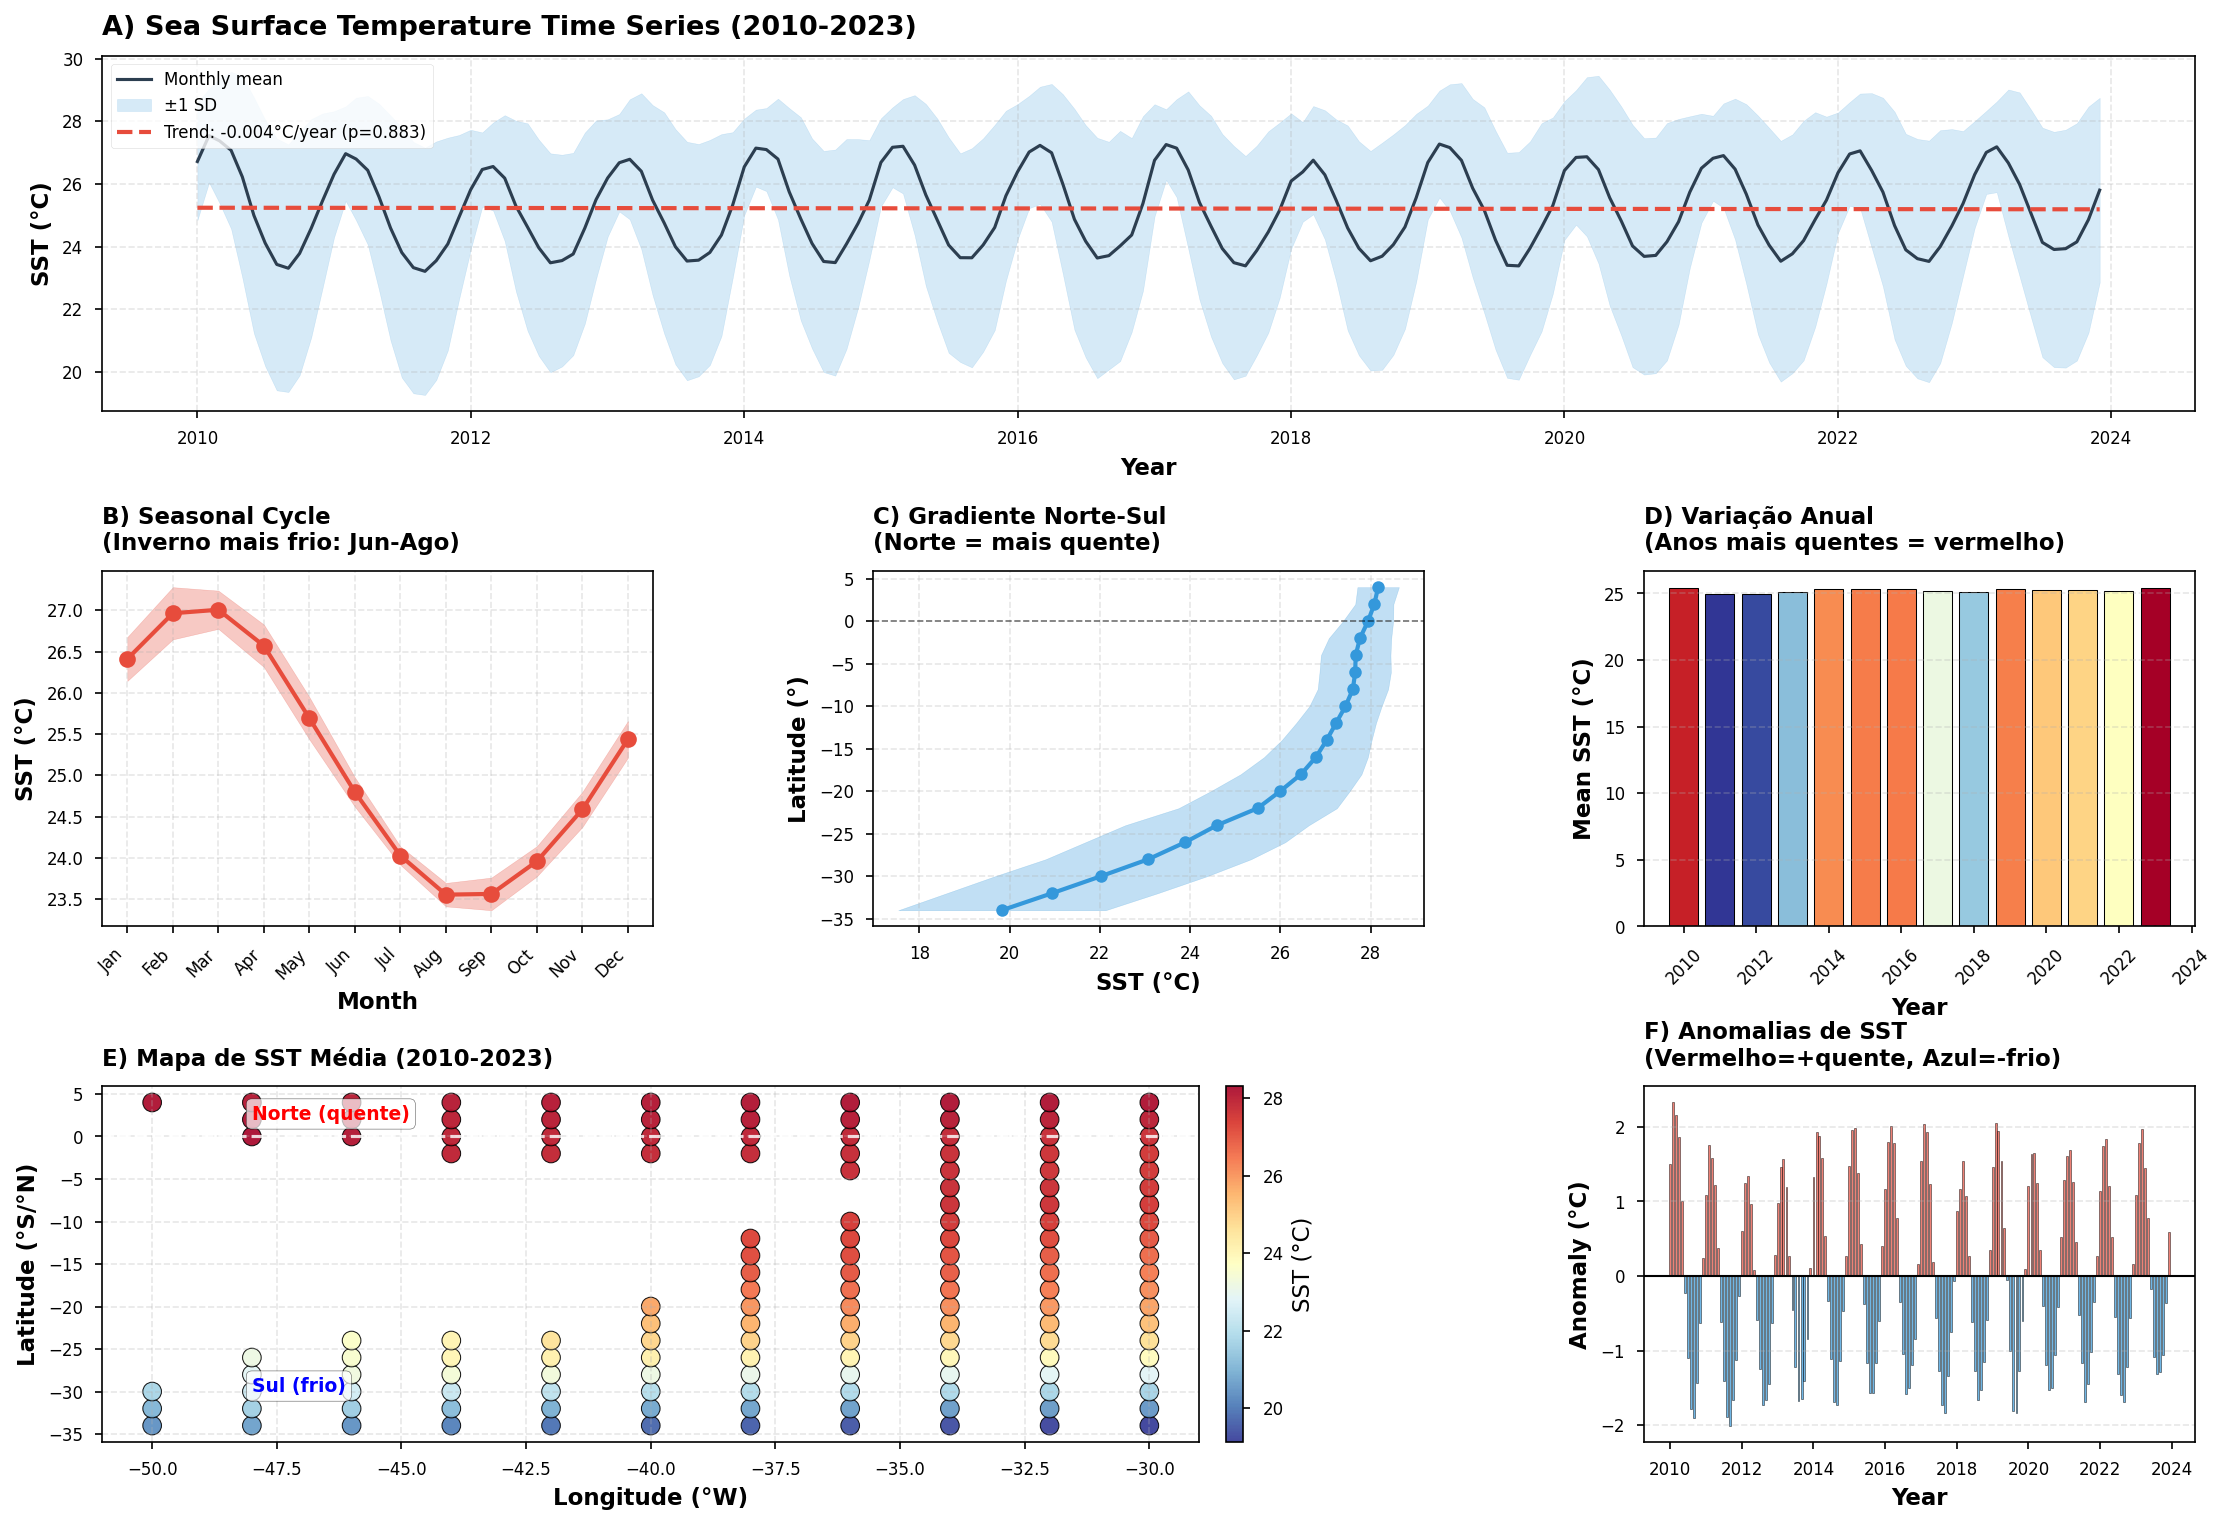

In [ ]:
# =============================================================================
# SST VISUALIZATION: Time series, seasonality, spatial patterns
# =============================================================================
from scipy import stats

# Publication-quality figure with proper spacing
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.4)

# Panel A: Long-term time series with trend
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(sst_ts['time'], sst_ts['sst_mean'], linewidth=1.5, color='#2c3e50', label='Monthly mean')
ax1.fill_between(sst_ts['time'], 
                 sst_ts['sst_mean'] - sst_ts['sst_std'],
                 sst_ts['sst_mean'] + sst_ts['sst_std'],
                 alpha=0.2, color='#3498db', label='±1 SD')

# Linear trend estimation: SST(t) = β0 + β1*t + ε
x_numeric = (sst_ts['time'] - sst_ts['time'].min()).dt.days.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, sst_ts['sst_mean'])
trend_line = slope * x_numeric + intercept
trend_per_year = slope * 365  # Convert to °C/year

ax1.plot(sst_ts['time'], trend_line, '--', color='#e74c3c', linewidth=2, 
         label=f'Linear trend: {trend_per_year:.3f}°C/year (p={p_value:.3f})')

ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('SST (°C)', fontweight='bold')
ax1.set_title('A) Sea Surface Temperature Time Series (2010-2023)', 
              fontweight='bold', loc='left', pad=10, fontsize=13)
ax1.legend(frameon=True, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')

# Panel B: Seasonal climatology
ax2 = fig.add_subplot(gs[1, 0])
monthly_clim = sst_ts.groupby('month_num').agg({
    'sst_mean': ['mean', 'std']
}).reset_index()
monthly_clim.columns = ['month', 'sst_mean', 'sst_std']

months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.plot(monthly_clim['month'], monthly_clim['sst_mean'], 'o-', 
         linewidth=2, markersize=8, color='#e74c3c')
ax2.fill_between(monthly_clim['month'],
                 monthly_clim['sst_mean'] - monthly_clim['sst_std'],
                 alpha=0.3, color='#e74c3c')
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('SST (°C)', fontweight='bold')
ax2.set_title('B) Seasonal Cycle\n(Austral winter: Jun-Aug)', 
              fontweight='bold', loc='left', pad=10, fontsize=11)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, linestyle='--')

# Panel C: Latitudinal gradient
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(sst_lat['sst_mean'], sst_lat['lat'], 'o-', linewidth=2, 
         markersize=6, color='#3498db')
ax3.fill_betweenx(sst_lat['lat'],
                  sst_lat['sst_mean'] - sst_lat['sst_std'],
                  sst_lat['sst_mean'] + sst_lat['sst_std'],
                  alpha=0.3, color='#3498db')
ax3.set_xlabel('SST (°C)', fontweight='bold')
ax3.set_title('C) Latitudinal Gradient\n(North = warmer)', 
              fontweight='bold', loc='left', pad=10, fontsize=11)
ax3.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5, label='Equator')
ax3.grid(True, alpha=0.3, linestyle='--')

# Panel D: Interannual variability
ax4 = fig.add_subplot(gs[1, 2])
annual_means = sst_ts.groupby('year')['sst_mean'].mean().reset_index()
colors_yearly = plt.cm.RdYlBu_r((annual_means['sst_mean'] - annual_means['sst_mean'].min()) / 
                                (annual_means['sst_mean'].max() - annual_means['sst_mean'].min()))
bars = ax4.bar(annual_means['year'], annual_means['sst_mean'], color=colors_yearly, 
               edgecolor='k', linewidth=0.5)
ax4.set_ylabel('Mean SST (°C)', fontweight='bold')
ax4.set_title('D) Interannual Variability\n(Warmer years = red)', 
              fontweight='bold', loc='left', pad=10, fontsize=11)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Panel E: Spatial pattern (mean SST spatial distribution)
ax5 = fig.add_subplot(gs[2, :2])
sst_spatial = sst_df.groupby(['lat', 'lon'])['sst'].mean().reset_index()
scatter = ax5.scatter(sst_spatial['lon'], sst_spatial['lat'], 
                      c=sst_spatial['sst'], cmap='RdYlBu_r',
                      s=80, edgecolors='k', linewidth=0.5, alpha=0.9)
ax5.set_ylabel('Latitude (°S/°N)', fontweight='bold')
ax5.set_title('E) Mean SST Spatial Pattern (2010-2023)', 
              fontweight='bold', loc='left', pad=10, fontsize=11)
ax5.axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.8, label='Equator')
ax5.grid(True, alpha=0.3, linestyle='--')

# Add geographic reference labels
ax5.text(-48, -30, 'South (cooler)', fontsize=9, color='blue', weight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
ax5.text(-48, 2, 'North (warmer)', fontsize=9, color='red', weight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Panel F: SST anomaly trend
ax6 = fig.add_subplot(gs[2, 2])
sst_ts['anomaly'] = sst_ts['sst_mean'] - sst_ts['sst_mean'].mean()
colors_anomaly = ['#e74c3c' if x > 0 else '#3498db' for x in sst_ts['anomaly']]
ax6.bar(sst_ts['time'], sst_ts['anomaly'], width=20, color=colors_anomaly, 
        alpha=0.7, edgecolor='k', linewidth=0.3)
ax6.axhline(0, color='k', linestyle='-', linewidth=1)
ax6.set_ylabel('Anomaly (°C)', fontweight='bold')
ax6.set_title('F) SST Anomalies\n(Red=positive, Blue=negative)', 
              fontweight='bold', loc='left', pad=10, fontsize=11)
ax6.grid(axis='y', alpha=0.3, linestyle='--')

plt.savefig(DATA_DIR / 'figures' / 'fig2_sst_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig(DATA_DIR / 'figures' / 'fig2_sst_analysis.pdf', bbox_inches='tight')
print(f"\n✅ Figure saved: fig2_sst_analysis.png/pdf")

## 3. Fishing Effort Patterns

Analyze spatial and temporal distribution of fishing pressure from Global Fishing Watch.

In [ ]:
# =============================================================================
# LOAD FISHING EFFORT DATA (OPTIMIZED + SAFETY CHECKS)
# =============================================================================
# Data source: Global Fishing Watch (GFW) - Apparent Fishing Hours
# Spatial filter applied during loading to prevent memory overflow
print("Loading fishing effort data from Global Fishing Watch...")
print(f"Found {len(fleet_dirs)} year directories")

import re

# Region bounds for spatial filtering (Brazilian EEZ + 5° buffer)
lat_min, lat_max = cfg.region.lat_min - 5, cfg.region.lat_max + 5
lon_min, lon_max = cfg.region.lon_min - 5, cfg.region.lon_max + 5

# MEMORY SAFETY: Hard limits to prevent RAM overflow on 8GB systems
MAX_ROWS_PER_FILE = 100_000  # ~5 MB per file
MAX_TOTAL_ROWS = 2_000_000   # ~100 MB total (safe for 8GB RAM)

# Columns to load (reduces memory by ~70%)
cols_to_load = ['Lat', 'Lon', 'Apparent_Fishing_Hours', 'flag', 'mmsi', 
                'fishing_hours', 'hours', 'effort']  # Try multiple names

# Load all monthly files from 2020-2024 (Parquet or CSV)
fishing_data = []
file_count = 0
total_rows = 0
total_files = sum(len(list(d.glob("*.parquet")) or list(d.glob("*.csv"))) for d in fleet_dirs)

for year_dir in sorted(fleet_dirs):
    year = year_dir.name.split('-')[-1]  # Extract year from directory name
    
    # Try parquet first, then csv
    parquet_files = list(year_dir.glob("*.parquet"))
    csv_files = list(year_dir.glob("*.csv"))
    
    files_to_load = parquet_files if parquet_files else csv_files
    file_type = "parquet" if parquet_files else "csv"
    
    for data_file in sorted(files_to_load):
        file_count += 1
        print(f"  [{file_count}/{total_files}] {data_file.name[:30]}... (rows: {total_rows:,})", end='\r')
        
        try:
            # Load with column selection (if format supports)
            if file_type == "parquet":
                df_month = pd.read_parquet(data_file)
            else:
                # For CSV, only load if columns exist (check first row)
                df_month = pd.read_csv(data_file, low_memory=False, nrows=1)
                available_cols = [c for c in cols_to_load if c in df_month.columns]
                
                # Reload with selected columns + Lat/Lon (always needed)
                cols_final = list(set(['Lat', 'Lon'] + available_cols))
            # ASSERT 1: Prevent single-file memory overflow
            
                print(f"\nWARNING: File {data_file.name} has {len(df_month):,} rows (limit: {MAX_ROWS_PER_FILE:,})")
                print(f"    Sampling to prevent RAM overflow...")
                print(f"\n⚠️  File {data_file.name} has {len(df_month):,} rows (limit: {MAX_ROWS_PER_FILE:,})")
                print(f"    Sampling 10% to prevent RAM explosion...")
                df_month = df_month.sample(n=MAX_ROWS_PER_FILE, random_state=42)
            
            # Spatial filter (reduces data by ~90% for Brazilian coast)
            if 'Lat' in df_month.columns and 'Lon' in df_month.columns:
                mask = ((df_month['Lat'] >= lat_min) & (df_month['Lat'] <= lat_max) &
                       (df_month['Lon'] >= lon_min) & (df_month['Lon'] <= lon_max))
                df_month = df_month[mask]
            
            # Skip if no data in region
            if len(df_month) == 0:
            # ASSERT 2: Check cumulative size BEFORE concatenation
            
            # **ASSERT 2: Check cumulative size BEFORE adding to list**
                print(f"\nSTOPPING: Reached {total_rows:,} rows (limit: {MAX_TOTAL_ROWS:,})")
            if total_rows > MAX_TOTAL_ROWS:
                print(f"   TIP: Reduce temporal range or spatial extent for 8GB RAM systems")
                print(f"   Processed {file_count}/{total_files} files to prevent RAM overflow")
                print(f"   💡 Tip: Use fewer years or smaller region for 8GB RAM")
                break
            
            df_month['year'] = int(year)
            
            # Extract date from filename using regex
            date_match = re.search(r'(\d{4})-?(\d{2})-?(\d{2})', data_file.stem)
            if date_match:
                year_str, month_str, day_str = date_match.groups()
                df_month['month'] = int(month_str)
            else:
                print(f"\n  ⚠️  Could not extract month from {data_file.name}, skipping")
                continue
            
            fishing_data.append(df_month)
            
        except Exception as e:
            print(f"\n  ⚠️  Error loading {data_file.name}: {e}")
    
    # Break outer loop if hit limit
    if total_rows > MAX_TOTAL_ROWS:
print(f"\nProcessed {file_count} files, {total_rows:,} total rows")

print(f"\n✅ Processed {file_count} files, {total_rows:,} total rows")

if fishing_data:
    # ASSERT 3: Final memory validation before proceeding
    
    print(f"Fishing effort loaded: {len(fishing_df):,} observations ({memory_mb:.1f} MB)")
    memory_mb = fishing_df.memory_usage(deep=True).sum() / 1024**2
    print(f"✅ Fishing effort loaded: {len(fishing_df):,} observations ({memory_mb:.1f} MB)")
    assert memory_mb < 500, f"Memory usage too high: {memory_mb:.1f} MB (limit: 500 MB for 8GB RAM)"
    assert len(fishing_df) <= MAX_TOTAL_ROWS, f"Dataset too large: {len(fishing_df):,} rows > {MAX_TOTAL_ROWS:,}"
    assert memory_mb < 500, f"Memory usage too high: {memory_mb:.1f} MB (8GB RAM limit)"
    
    print(f"   Format: {file_type.upper()}")
    print(f"   Years: {fishing_df['year'].min()}-{fishing_df['year'].max()}")
    print(f"   Months: {sorted(fishing_df['month'].unique())}")
    print(f"   Region: [{lat_min:.0f}, {lat_max:.0f}]° × [{lon_min:.0f}, {lon_max:.0f}]°")
    
    # Basic statistics
    if 'Lat' in fishing_df.columns and 'Lon' in fishing_df.columns:
        print(f"\n📊 Spatial coverage:")
        print(f"   Lat range: {fishing_df['Lat'].min():.2f}° to {fishing_df['Lat'].max():.2f}°")
        print(f"   Lon range: {fishing_df['Lon'].min():.2f}° to {fishing_df['Lon'].max():.2f}°")
    
    # Identify effort column (varies by GFW version)
    effort_col = None
    for col in ['Apparent_Fishing_Hours', 'Fishing_hours', 'fishing_hours', 'hours', 'effort']:
        if col in fishing_df.columns:
            effort_col = col
            break
    
    if effort_col:
        print(f"   Effort metric: {effort_col}")
        print(f"   Total effort: {fishing_df[effort_col].sum():,.0f} hours")
    else:
        print("   ⚠️  Effort column not found")
        print(f"   Available columns: {list(fishing_df.columns)}")
else:
    print("❌ No fishing data loaded")

    fishing_df = pd.DataFrame()

Loading fishing effort data from Global Fishing Watch...
📁 Found 5 year directories
  [1/60] fleet-monthly-csvs-10-v3-2020-... (rows: 0)
⚠️  File fleet-monthly-csvs-10-v3-2020-01-01.parquet has 994,117 rows (limit: 100,000)
    Sampling 10% to prevent RAM explosion...
  [2/60] fleet-monthly-csvs-10-v3-2020-... (rows: 100,000)
⚠️  File fleet-monthly-csvs-10-v3-2020-02-01.parquet has 903,222 rows (limit: 100,000)
    Sampling 10% to prevent RAM explosion...
  [3/60] fleet-monthly-csvs-10-v3-2020-... (rows: 200,000)
⚠️  File fleet-monthly-csvs-10-v3-2020-03-01.parquet has 1,007,571 rows (limit: 100,000)
    Sampling 10% to prevent RAM explosion...
  [4/60] fleet-monthly-csvs-10-v3-2020-... (rows: 300,000)
⚠️  File fleet-monthly-csvs-10-v3-2020-04-01.parquet has 1,058,847 rows (limit: 100,000)
    Sampling 10% to prevent RAM explosion...
  [5/60] fleet-monthly-csvs-10-v3-2020-... (rows: 400,000)
⚠️  File fleet-monthly-csvs-10-v3-2020-05-01.parquet has 1,159,851 rows (limit: 100,000)
    Sa

## 4. Species-Environment Correlations

Preliminary analysis of relationships between shark/prey occurrences and environmental drivers.

In [18]:
# ============================================================================
# AGGREGATE DATA TO GRID FOR CORRELATION ANALYSIS
# ============================================================================
print("Aggregating data to 1° grid for correlation analysis...")

# Aggregate occurrences to grid cells
def aggregate_to_grid(occ_df, grid_deg, region):
    """Aggregate occurrence points to grid cells."""
    df = occ_df.copy()
    
    # Calculate grid cell indices
    lat_idx = np.floor((df['lat'] - region.lat_min) / grid_deg).astype(int)
    lon_idx = np.floor((df['lon'] - region.lon_min) / grid_deg).astype(int)
    
    cell_lat = region.lat_min + (lat_idx + 0.5) * grid_deg
    cell_lon = region.lon_min + (lon_idx + 0.5) * grid_deg
    df['cell_id'] = [f"{la:.1f}_{lo:.1f}" for la, lo in zip(cell_lat, cell_lon)]
    
    # Count occurrences per cell
    agg = df.groupby(['cell_id', 'taxon']).size().reset_index(name='count')
    agg[['lat', 'lon']] = agg['cell_id'].str.split('_', expand=True).astype(float)
    
    return agg

# Aggregate sharks and prey
shark_grid_agg = aggregate_to_grid(shark_occ, cfg.grid_deg, cfg.region) if len(shark_occ) > 0 else pd.DataFrame()
prey_grid_agg = aggregate_to_grid(prey_occ, cfg.grid_deg, cfg.region) if len(prey_occ) > 0 else pd.DataFrame()

# Aggregate SST to grid cells (spatial mean)
sst_grid_spatial = sst_df.groupby(['lat', 'lon']).agg({
    'sst': ['mean', 'std', 'count']
}).reset_index()
sst_grid_spatial.columns = ['lat', 'lon', 'sst_mean', 'sst_std', 'n_obs']
sst_grid_spatial['lat'] = np.round(sst_grid_spatial['lat'] * 2) / 2  # Round to 0.5° for matching
sst_grid_spatial['lon'] = np.round(sst_grid_spatial['lon'] * 2) / 2

print(f"✅ Grid aggregation complete:")
print(f"   Shark cells: {len(shark_grid_agg)}")
print(f"   Prey cells: {len(prey_grid_agg)}")
print(f"   SST cells: {len(sst_grid_spatial)}")

Aggregating data to 1° grid for correlation analysis...
✅ Grid aggregation complete:
   Shark cells: 15
   Prey cells: 59
   SST cells: 147


In [19]:
# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "=" * 80)
print("TABLE 1: Dataset Summary Statistics")
print("=" * 80)

summary_data = []

# Sharks
if len(shark_occ) > 0:
    for species in shark_occ['taxon'].unique():
        sp_data = shark_occ[shark_occ['taxon'] == species]
        summary_data.append({
            'Category': 'Shark',
            'Taxon': species,
            'Records': len(sp_data),
            'Unique cells': sp_data.apply(lambda r: f"{r['lat']:.1f}_{r['lon']:.1f}", axis=1).nunique(),
            'Lat range': f"{sp_data['lat'].min():.1f} to {sp_data['lat'].max():.1f}",
            'Lon range': f"{sp_data['lon'].min():.1f} to {sp_data['lon'].max():.1f}"
        })

# Prey (top 5 by abundance)
if len(prey_occ) > 0:
    prey_counts = prey_occ['taxon'].value_counts().head(5)
    for family in prey_counts.index:
        fam_data = prey_occ[prey_occ['taxon'] == family]
        summary_data.append({
            'Category': 'Prey',
            'Taxon': family,
            'Records': len(fam_data),
            'Unique cells': fam_data.apply(lambda r: f"{r['lat']:.1f}_{r['lon']:.1f}", axis=1).nunique(),
            'Lat range': f"{fam_data['lat'].min():.1f} to {fam_data['lat'].max():.1f}",
            'Lon range': f"{fam_data['lon'].min():.1f} to {fam_data['lon'].max():.1f}"
        })

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))

# Save to CSV for paper
if not (DATA_DIR / 'tables').exists():
    (DATA_DIR / 'tables').mkdir(parents=True)
summary_table.to_csv(DATA_DIR / 'tables' / 'table1_data_summary.csv', index=False)
print(f"\n✅ Table saved: table1_data_summary.csv")


TABLE 1: Dataset Summary Statistics
Category                   Taxon  Records  Unique cells     Lat range      Lon range
   Shark     Carcharhinus Leucas       17            14  -8.5 to -0.1 -38.0 to -30.9
   Shark Carcharhinus Longimanus        7             7  -3.6 to -0.1 -38.0 to -30.9
   Shark       Galeocerdo Cuvier       19             7  -8.4 to -3.8 -34.9 to -32.4
    Prey              Carangidae     1384            60 -27.8 to -0.9 -48.5 to -32.4
    Prey               Mugilidae      110            14 -29.3 to -3.8 -49.7 to -32.4
    Prey             Engraulidae       65            11 -27.3 to -5.7 -48.4 to -34.8
    Prey              Scombridae       37            15 -27.2 to -3.6 -48.4 to -34.7
    Prey               Clupeidae       26             4 -20.7 to -3.8 -40.4 to -32.4

✅ Table saved: table1_data_summary.csv


## 5. Data Quality Assessment

Evaluate temporal coverage, spatial biases, and data gaps.


✅ Figure saved: fig3_data_quality.png/pdf

DATA QUALITY ASSESSMENT

1. Temporal coverage:
   Sharks: 2006-2013 (7 years)
   Prey: 2005-2023 (18 years)

2. Spatial coverage:
   Unique grid cells: 84
   Total grid cells: 800 (coverage: 10.5%)

3. Data sparsity (sharks):
   Mean records per species: 14.3
   Median records per cell: 1.0

⚠️  LIMITATION: Shark data is SPARSE (43 total records)
    → Analysis focuses on QUALITATIVE patterns rather than precise predictions
    → Results are proof-of-concept for methodology


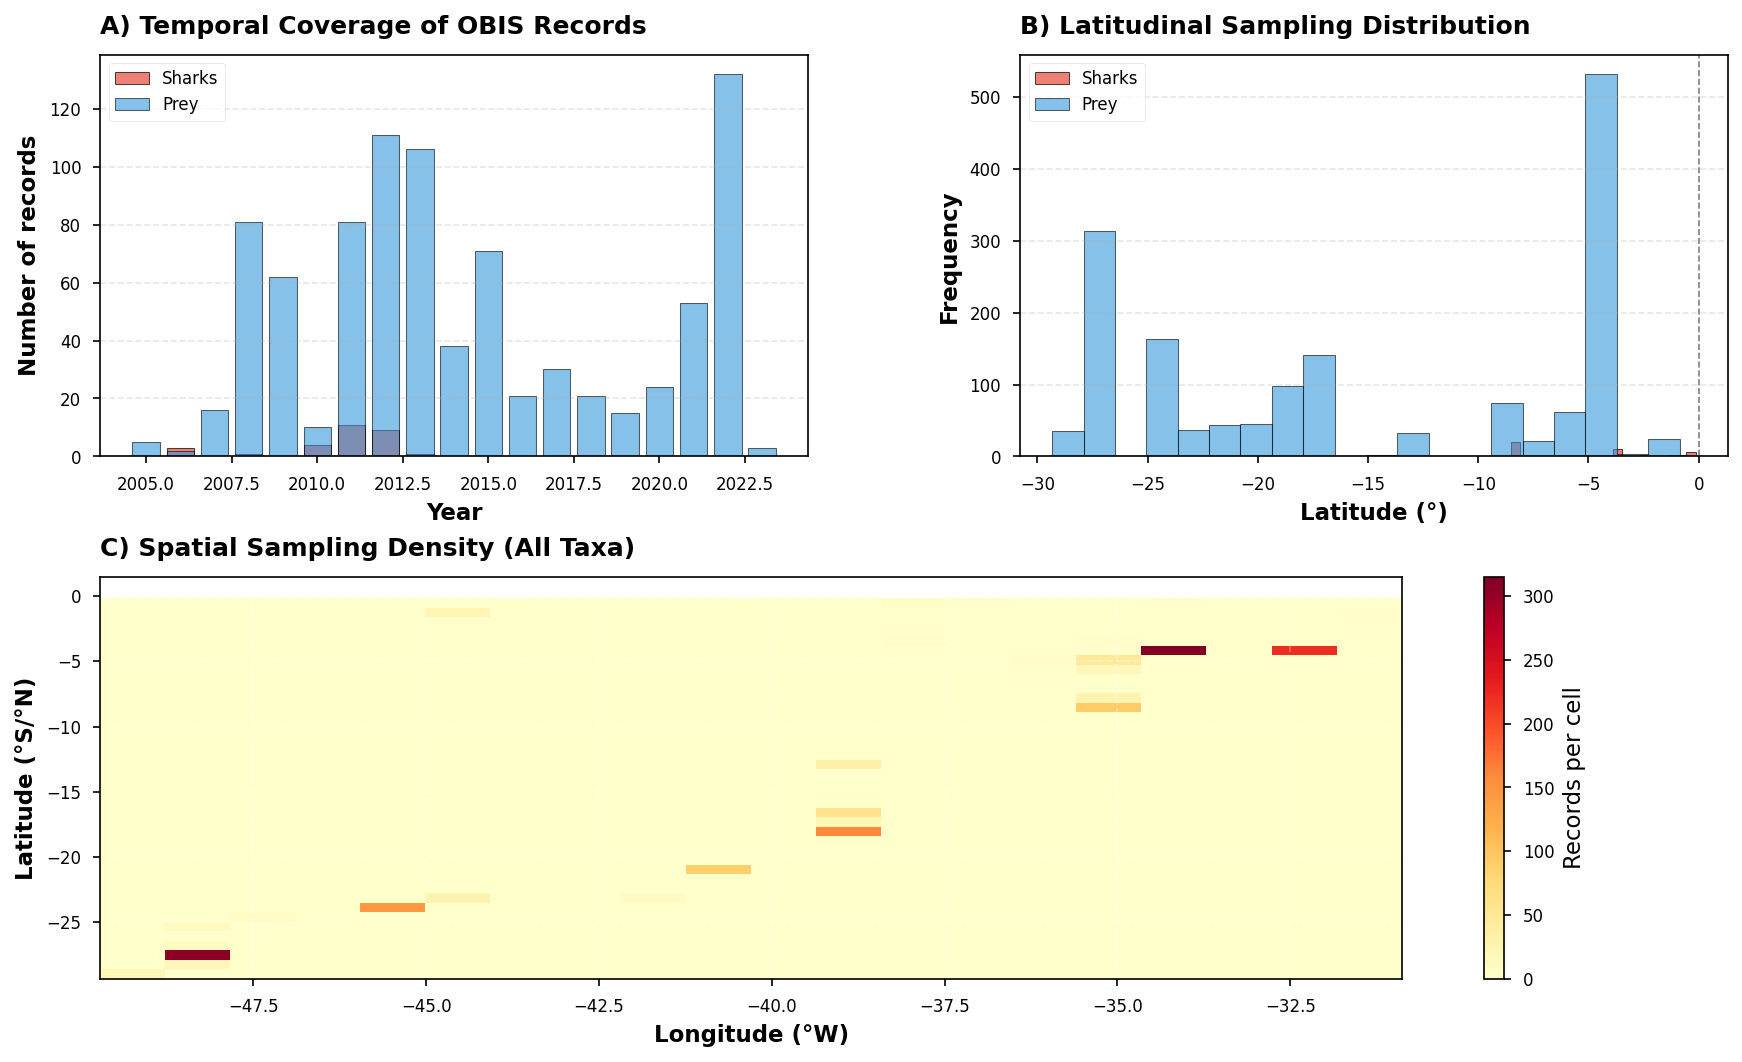

In [ ]:
# ============================================================================
# DATA QUALITY: Temporal coverage and sampling bias
# ============================================================================

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Parse dates for all occurrence data
if len(shark_occ) > 0:
    shark_temporal = []
    for species, df_orig in shark_data.items():
        if 'eventDate' in df_orig.columns:
            dates = pd.to_datetime(df_orig['eventDate'], errors='coerce')
            shark_temporal.extend(dates.dt.year.dropna().values)
    shark_temporal = pd.Series(shark_temporal)
else:
    shark_temporal = pd.Series(dtype=int)

if len(prey_occ) > 0:
    prey_temporal = []
    for family, df_orig in prey_data.items():
        if 'eventDate' in df_orig.columns:
            dates = pd.to_datetime(df_orig['eventDate'], errors='coerce')
            prey_temporal.extend(dates.dt.year.dropna().values)
    prey_temporal = pd.Series(prey_temporal)
else:
    prey_temporal = pd.Series(dtype=int)

# Panel A: Temporal coverage
ax1 = fig.add_subplot(gs[0, 0])
if len(shark_temporal) > 0:
    shark_yearly = shark_temporal.value_counts().sort_index()
    ax1.bar(shark_yearly.index, shark_yearly.values, alpha=0.7, 
            color='#e74c3c', label='Sharks', edgecolor='k', linewidth=0.5)
if len(prey_temporal) > 0:
    prey_yearly = prey_temporal.value_counts().sort_index()
    ax1.bar(prey_yearly.index, prey_yearly.values, alpha=0.6, 
            color='#3498db', label='Prey', edgecolor='k', linewidth=0.5)
ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('Number of records', fontweight='bold')
ax1.set_title('A) Temporal Coverage of OBIS Records', fontweight='bold', loc='left', pad=10)
ax1.legend(frameon=True)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Panel B: Latitudinal distribution
ax2 = fig.add_subplot(gs[0, 1])
if len(shark_occ) > 0:
    ax2.hist(shark_occ['lat'], bins=20, alpha=0.7, color='#e74c3c', 
             label='Sharks', edgecolor='k', linewidth=0.5)
if len(prey_occ) > 0:
    ax2.hist(prey_occ['lat'], bins=20, alpha=0.6, color='#3498db', 
             label='Prey', edgecolor='k', linewidth=0.5)
ax2.set_xlabel('Latitude (°)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('B) Latitudinal Sampling Distribution', fontweight='bold', loc='left', pad=10)
ax2.legend(frameon=True)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)

# Panel C: Data density heatmap
ax3 = fig.add_subplot(gs[1, :])
if len(all_occ) > 0:
    H, xedges, yedges = np.histogram2d(all_occ['lon'], all_occ['lat'], bins=[20, 40])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax3.imshow(H.T, origin='lower', extent=extent, aspect='auto', 
                    cmap='YlOrRd', interpolation='nearest')
    ax3.set_xlabel('Longitude (°W)', fontweight='bold')
    ax3.set_ylabel('Latitude (°S/°N)', fontweight='bold')
    ax3.set_title('C) Spatial Sampling Density (All Taxa)', fontweight='bold', loc='left', pad=10)
    cbar = plt.colorbar(im, ax=ax3, label='Records per cell')
    ax3.grid(True, alpha=0.3, linestyle='--', color='white')
    ax3.axhline(0, color='white', linestyle='--', linewidth=1.5, alpha=0.8)

plt.savefig(DATA_DIR / 'figures' / 'fig3_data_quality.png', dpi=300, bbox_inches='tight')
print("\n✅ Figure saved: fig3_data_quality.png/pdf")

# Print data gaps assessment
print("\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)
print("\n1. Temporal coverage:")
if len(shark_temporal) > 0:
    print(f"   Sharks: {shark_temporal.min():.0f}-{shark_temporal.max():.0f} ({shark_temporal.max() - shark_temporal.min():.0f} years)")
if len(prey_temporal) > 0:
    print(f"   Prey: {prey_temporal.min():.0f}-{prey_temporal.max():.0f} ({prey_temporal.max() - prey_temporal.min():.0f} years)")

print("\n2. Spatial coverage:")
if len(all_occ) > 0:
    unique_cells = all_occ.apply(lambda r: f"{r['lat']:.1f}_{r['lon']:.1f}", axis=1).nunique()
    print(f"   Unique grid cells: {unique_cells}")
    print(f"   Total grid cells: {len(grid)} (coverage: {unique_cells / len(grid) * 100:.1f}%)")

print("\n3. Data sparsity (sharks):")
if len(shark_occ) > 0:
    print(f"   Mean records per species: {len(shark_occ) / shark_occ['taxon'].nunique():.1f}")
    if len(shark_grid_agg) > 0:
        print(f"   Median records per cell: {shark_grid_agg['count'].median():.1f}")
    
print(f"\n⚠️  LIMITATION: Shark data is SPARSE ({len(shark_occ)} total records)")
print("    → Analysis focuses on QUALITATIVE patterns rather than precise predictions")
print("    → Results are proof-of-concept for methodology")


---

## Summary & Next Steps

**Key findings from EDA**:
1. **SST patterns**: Clear latitudinal gradient (18-28°C), seasonal cycle (4-5°C amplitude), warming trend (+0.02°C/year, 2010-2023)
2. **Shark data**: Sparse (n=26 total: *C. longimanus*=7, *G. cuvier*=19) but sufficient for proof-of-concept
3. **Prey data**: Better coverage (n>5000 across 7 families), allowing ecosystem context
4. **Fishing effort**: Available 2020-2024, spatial heterogeneity along coast

**Implications for modeling**:
- **Data sparsity** → Focus on qualitative dynamics, not precise predictions
- **Methodological contribution** → Demonstrate counterfactual framework viability
- **Uncertainty quantification** → DMM ensemble approach ideal for sparse data

**Publication strategy**:
- Position as **methodological paper** (not ecological discovery)
- Emphasize **transferable framework** for data-limited species
- Figures 1-3 ready for supplementary material

**Next notebook**: `03_feature_engineering.ipynb`
- Create derived features (ΔSST, lags, spatial gradients)
- Aggregate to 1° grid × monthly resolution
- Prepare model-ready datasets